In [4]:
import pandas as pd
import numpy as np

import pymorphy2
import re
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier


# Методы семантического анализа текстов

## Сходство между словами

You shall know a word by the company it keeps. 

*Frith*

 Варкалось. Хливкие шорьки<br>
   Пырялись по наве,<br>
   И хрюкотали зелюки,<br>
   Как мюмзики в мове.<br>

*Кэррол*

Не очень ясно что именно могут делать *зелюки*. Но если мы узнаем кто еще может *хрюкотать*, то мы можем посчитать, что нашли слово со сходным значением или, как минимум, относящееся к одной смысловой группе.

Аналогично мы не понимаем кто (что) такие *шорьки*. Если они бывают ответственными - это одно, если электронными - другое.

Модель описана в статье [Т.Миколова и др.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Идея метода основывается на оптимизации функционала, основанного на логарифмах вероятностей совместной встречаемости слов. Помимо этого, вводятся отрицательные примеры, вероятности которых не суммируются, а вычитаются. При этом отрицательных примеров берется больше, чем положительных.

- Возьмем текст и разделим его на слова, выделим слова со значимыми частями речи.
- Пройдемся по всем словам текста. Возьмем несколько соседних слов справа и слева от текущего. Посчитаем частоты их совместной встречаемости.
- Отсеем все слова, которые встречаются слишком редко или с малым количеством других слов.

In [5]:
import pandas as pd
import re
import nltk
import nltk.data
from tqdm.notebook import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/edward/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
with open("data/lenta2018_summer2.txt", encoding="utf-8") as newsfile: # Файл с новостями.
    text = newsfile.read()
    div_text = text.split("=====\n")[1:]
    text_news = [(n.split('\n')[0], '\n'.join(n.split('\n')[2:])) 
                 for n in div_text]
    news = pd.DataFrame(text_news, columns = ['Header', 'News'])

In [7]:
news.head()

,Header,News
0,«Королева дерьмовых роботов» перенесла операци...,-----\nШведская YouTube-знаменитость Симона Ге...
1,У Су-57 нашли «тайные ноу-хау»,-----\nПерспективный российский многофункциона...
2,Знарок лишился еще одного поста,-----\nСанкт-петербургский клуб Континентально...
3,СК заинтересовался задержанием аутиста московс...,-----\nСледственный комитет по Москве начал пр...
4,Киевляне перекрыли проспект из-за сбитого поли...,-----\nБолее 100 жителей Киева перекрыли просп...


Давайте поделим тексты на предложения, а предложения на слова

In [8]:
def text_to_sentences(text):
    sentences = []
    tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
    raw_sentences = tokenizer.tokenize(text.strip())
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(re.sub('[^a-zA-Zа-яА-яёЁ]', ' ', raw_sentence).lower().split())
    return sentences

In [9]:
text_to_sentences(news['News'][11])

[['молиться',
  'и',
  'воздерживаться',
  'от',
  'секса',
  'посоветовали',
  'геям',
  'в',
  'гонконге',
  'чтобы',
  'излечить',
  'свою',
  'гомосексуальность'],
 ['об', 'этом', 'сообщает', 'reuters'],
 ['кроме',
  'этих',
  'способов',
  'для',
  'излечения',
  'геям',
  'необходимо',
  'выглядеть',
  'как',
  'мачо',
  'перестать',
  'смотреть',
  'порно',
  'и',
  'избегать',
  'общества',
  'других',
  'мужчин'],
 ['некоторые',
  'геи',
  'также',
  'посещали',
  'сеансы',
  'терапии',
  'и',
  'молитвы',
  'во',
  'время',
  'которых',
  'как',
  'им',
  'сообщали',
  'их',
  'ориентация',
  'станет',
  'традиционной'],
 ['создатели',
  'таких',
  'программ',
  'реабилитации',
  'чаще',
  'всего',
  'консервативные',
  'христиане',
  'уверены',
  'что',
  'гомосексуальность',
  'осознанный',
  'выбор',
  'человека'],
 ['один',
  'из',
  'прошедших',
  'реабилитационный',
  'курс',
  'сообщил',
  'агентству',
  'что',
  'после',
  'таких',
  'сеансов',
  'он',
  'потерял',
  

In [10]:
news['News'][0]

'-----\nШведская YouTube-знаменитость Симона Герц (Simone Giertz), прославившаяся необычными изобретениями, перенесла операцию. Об этом рассказали ее представители в Twitter. Еще в конце апреля девушка сообщила подписчикам о недуге. Оказалось, что у нее в мозге обнаружили доброкачественную опухоль размером с мяч для гольфа. Блогер даже дала ей имя, назвав новообразование Брайаном.  Герц сильно переживала перед хирургическим вмешательством. В одном из предоперационных видео она говорила, что очень напугана. Однако врачи быстро удалили опухоль и спасли девушке жизнь. «Симона вышла из хирургии, и ее врачи очень довольны тем, как все прошло. Она проспала достаточно долго, чтобы сделать неуместную шутку, так что все хорошо», — говорится на ее странице в Twitter.  27-летняя изобретательница из Стокгольма прославилась несколько лет назад, показывая подписчикам свои бесполезные изобретения. Например, Герц демонстрировала самодельный будильник, к которому приделана резиновая рука, избивающая сп

In [11]:
all_sentences = sum([text_to_sentences(x) for x in news['News']], [])

In [12]:
all_sentences[0]

['шведская',
 'youtube',
 'знаменитость',
 'симона',
 'герц',
 'simone',
 'giertz',
 'прославившаяся',
 'необычными',
 'изобретениями',
 'перенесла',
 'операцию']

## Модель Word2Vec

In [13]:
# Импортируем библиотеки Word2Vec
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models import KeyedVectors # Семантические вектора.

### Использование предобученных моделей

Теперь загрузим модель, обученную разработчиками проекта <a href="http://rusvectores.org/ru/models/">RusVectores</a> для русского языка на новостях. В зависимости от того, откуда вы берете модели, они могут загружаться по-разному. Более того, модель можно обучить самому - для этого нужно просто взять много размеченных текстов.

In [14]:
model_w2v = KeyedVectors.load_word2vec_format('data/araneum_upos_skipgram_300_2_2018.vec.gz')

Теперь можно получить представление слов в новом пространстве. Имейте в виду, что в данной модели они идут с частями речи!

In [15]:
model_w2v['огонь_NOUN']

array([-2.69010e-02,  1.08851e-01,  1.13100e-03, -2.76620e-02,
       -2.50680e-02, -4.58600e-03, -1.26100e-03, -3.79600e-03,
       -7.53080e-02, -2.39490e-02,  2.00400e-02,  6.10330e-02,
        7.40810e-02,  9.56330e-02, -1.11446e-01,  4.60380e-02,
       -2.24540e-02, -2.46080e-02, -8.82250e-02, -1.53180e-02,
       -3.66000e-04, -9.46770e-02,  1.33686e-01,  5.88400e-03,
       -5.05470e-02,  8.13820e-02, -2.88090e-02, -7.00070e-02,
        8.74950e-02, -8.31860e-02, -2.48210e-02, -3.82660e-02,
        6.13210e-02, -6.45530e-02,  2.66400e-03,  8.36140e-02,
       -3.73850e-02,  3.63260e-02, -1.20000e-04, -6.90000e-02,
        1.49810e-02,  3.03880e-02, -2.17280e-02,  2.79400e-02,
       -5.22550e-02,  1.96660e-02,  1.52499e-01,  7.27100e-02,
       -2.11140e-02,  5.69930e-02, -3.07870e-02,  4.09070e-02,
        6.49290e-02,  1.91730e-02,  2.50080e-02, -2.94090e-02,
        6.33780e-02,  1.09028e-01,  5.66630e-02, -3.62330e-02,
        4.96900e-02, -7.09280e-02,  2.74420e-02, -1.986

In [16]:
model_w2v.most_similar('интернет_NOUN')

[('интеренет_NOUN', 0.9242964386940002),
 ('интерент_NOUN', 0.915547251701355),
 ('интренет_NOUN', 0.9038119316101074),
 ('интрнет_NOUN', 0.8466424942016602),
 ('итернет_NOUN', 0.8340107202529907),
 ('интенета_NOUN', 0.8012408018112183),
 ('инетрнет_NOUN', 0.7921423316001892),
 ('интерет_NOUN', 0.786211371421814),
 ('инетернет_NOUN', 0.7794284224510193),
 ('интернт_NOUN', 0.7663599848747253)]

In [17]:
model_w2v.most_similar('ученый_NOUN')

[('исследователь_NOUN', 0.8123084902763367),
 ('биолог_NOUN', 0.7502084374427795),
 ('астрофизик_NOUN', 0.7438788414001465),
 ('ученый_ADJ', 0.7298716306686401),
 ('нейрофизиолог_NOUN', 0.7224254608154297),
 ('нейробиолог_NOUN', 0.7219529747962952),
 ('климатолог_NOUN', 0.7159755825996399),
 ('зоолог_NOUN', 0.7055575251579285),
 ('астроном_NOUN', 0.700603723526001),
 ('палеонтолог_NOUN', 0.6994453072547913)]

В пространстве Word2Vec возможны векторные операции. Попробуем их.

In [18]:
#model_w2v.most_similar(positive=[u'пожар_NOUN'])
#model_w2v.most_similar(positive=[u'пожар_NOUN'], negative=[u'пламя_NOUN' ])
#model_w2v.most_similar(positive=[u'топливо_NOUN', u'молоко_NOUN'], negative=[u'нефть_NOUN' ])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
model_w2v.most_similar(positive=[u'король_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
#model_w2v.most_similar(positive=[u'президент_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
# model_w2v.most_similar(negative=[u'король_NOUN', u'мужчина_NOUN'], positive=[u'женщина_NOUN'])
# model_w2v.most_similar(positive=[u'король_NOUN', u'мужчина_NOUN'], negative=[u'женщина_NOUN'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'король_NOUN' ])
#model_w2v.most_similar(positive=[u'берлин_PROPN', u'москва_PROPN' ], negative=[u'германия_PROPN'])


[('королева_NOUN', 0.7022064924240112),
 ('герцог_NOUN', 0.6763379573822021),
 ('монарх_NOUN', 0.6703873872756958),
 ('генрих_PROPN', 0.656510055065155),
 ('людовик_PROPN', 0.6564112901687622),
 ('франция::людовик_PROPN', 0.6421706080436707),
 ('принц_NOUN', 0.640705943107605),
 ('королевство_NOUN', 0.6257355809211731),
 ('наследный_ADJ', 0.6177536845207214),
 ('герцогиня_NOUN', 0.617081344127655)]

Можно найти лишнее слово в последовательности.

In [19]:
model_w2v.doesnt_match(['лук_NOUN', 'перец_NOUN', 'ученик_NOUN', 'плодовый_ADJF'])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'ученик_NOUN'

Итак, вместо самих слов мы можем использовать их векторные представления в некотором семантическом пространстве.

<img src="img/cartoon-espresso-word2vec.jpg">

Беда Word2Vec состоит в том, что он генерирует только один вектор на каждое слово. То есть он не различает различных смыслов одного слова.

<img src="img/cartoon-citizen-data-scientist.jpg">

В полученном пространстве работают векторные операции. Если обучиться на достаточно большом количестве текстов, можно получить следующие эффекты.

![](img/w2v_vect.png)

![](img/w2v_vect2.png)



На хорошо обученной модели можно даже превратить индекс в город и наоборот при помощи векторных операций.

Давайте посмотрим на реальное расположение слов в этом пространстве. Для этого нам потребуется UMAP, а то как еще мы преобразуем 300-мерное пространство в плоскость?

In [20]:
from umap import UMAP
from copy import copy

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 12)

In [21]:
trees = pd.read_csv("data/trees.txt", sep='\t', names=['trees'])
herbs = pd.read_csv("data/herbs.txt", sep='\t', names=['herbs'])
trees = trees['trees'].str.lower().unique()
herbs = herbs['herbs'].str.lower().unique()

In [22]:
men_avg, women_avg = np.zeros(model_w2v.vector_size), np.zeros(model_w2v.vector_size)
men_count, women_count = 0, 0
men_vect, women_vect, animal_type, animal_no = [], [], [], []
dif_vect = []
names = []
men_names, women_names = [], []

for m in trees:
    if m.strip().lower()+'_NOUN' in model_w2v.vocab.keys():
        mv = model_w2v[m.strip().lower()+'_NOUN']
        men_avg += mv
        men_count += 1
        men_vect.append(mv)
        men_names.append(m)
        animal_type.append(1)
        
for w in herbs:
    if w.strip().lower()+'_NOUN' in model_w2v.vocab.keys():
        wv = model_w2v[w.strip().lower()+'_NOUN']
        women_avg += wv
        women_count += 1
        women_vect.append(wv)
        women_names.append(w)
        animal_type.append(0)

        
for i in range(men_count):
    mv = men_vect[i]
    animal_no.append(i)
    for j in range(women_count):
        wv = women_vect[j]
        dif_vect.append(mv - wv)
        names.append([men_names[i], women_names[j]])

men_avg /= men_count
women_avg /= women_count

dif_avg = men_avg - women_avg
cosines = KeyedVectors.cosine_similarities(dif_avg, dif_vect)

#print(list(zip(names, cosines)))
print([(n, c) for n, c in list(zip(names, cosines)) if c>0.6])

[(['клен', 'маргаритка'], 0.6117089698392721), (['клен', 'настурция'], 0.6115848257569042), (['клен', 'дельфиниум'], 0.6010003968890965), (['черешня', 'щавель'], 0.6182821208457462), (['черешня', 'редис'], 0.6446437627648164), (['самшит', 'настурция'], 0.6133552135715983), (['сосна', 'настурция'], 0.6001034566353993)]


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:902: RuntimeWarning: invalid value encountered in true_divide
  similarities = dot_products / (norm * all_norms)


In [23]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP().fit_transform(all_vect)

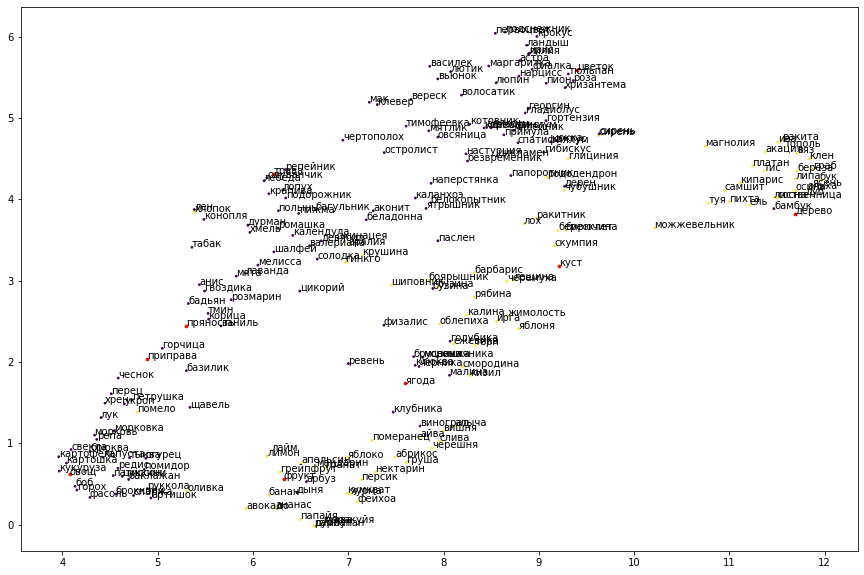

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=animal_type, s=3)

for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
    ind = all_names.index(word)
    ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)

for n, v in zip(all_names, umaped_vct):
    ax.annotate(n, (v[0], v[1]))

plt.show()

А теперь давайте добавим ещё одно измерение и посмотрим, как точки будут меняться вдоль него.

In [25]:
from ipywidgets import interact, FloatSlider

In [26]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP(n_components=3).fit_transform(all_vect)

In [27]:
def drawHerbs(val):
    fig, ax = plt.subplots()
    fig.set_size_inches(15,10)
    temp_data = np.array([u for u in umaped_vct if u[2]>=val-0.5 and u[2]<=val+0.5])
    temp_names = [all_names[i] for i, u in enumerate(umaped_vct) if u[2]>=val-0.5 and u[2]<=val+0.5]
    
    ax.scatter(temp_data[:, 0], temp_data[:, 1], c=temp_data[:, 2], s=30)

    for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
        ind = all_names.index(word)
        ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)
        ax.annotate(word, (umaped_vct[ind, 0], umaped_vct[ind, 1]))

    for n, v in zip(temp_names, temp_data):
        ax.annotate(n, (v[0], v[1]))

    plt.show()

In [28]:
sld1 = FloatSlider(value=(min(umaped_vct[:, 2])+max(umaped_vct[:, 2]))/2, min=min(umaped_vct[:, 2]), max=max(umaped_vct[:, 2]), step=0.1, description='Filter by Z')

interact(drawHerbs, val=sld1);

interactive(children=(FloatSlider(value=7.2113847732543945, description='Filter by Z', max=9.775031089782715, …

### Обучение собственной модели в Word2Vec


In [29]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 3     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model_our_news = Word2Vec(all_sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 40.3 s, sys: 261 ms, total: 40.6 s
Wall time: 18.3 s


Возьмем по тысяче научных текстов из пяти разных областей науки. (Они занимают 140 Мб и не влезают на Гит, так что доступны по запросу.)

In [30]:
sci_texts = pd.read_csv("data/kaggle-science-texts_train.tsv", header=0, sep = ';')

In [31]:
%%time
# Считаем матрицу термин-документ, но не с частотами, а со значениями Tf*Idf
X = TfidfVectorizer().fit_transform(sci_texts['Text'])
# Проводим SVD-разложение по 20 компонентам.

NameError: name 'TruncatedSVD' is not defined

Исходно, код выше выполнялся 37 минут. Но если поставить<br>
`pip install pymorphy2[fast]`<br>
то библиотека начинает работать горазо быстрее.

Если морфология работает медленно, но в тексте вссегда есть повторяющиеся слова (помните закон Ципфа?), то может быть результаты медленной морфологии надо кешировать в быстром словаре (dict)?

In [32]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [33]:
%%time
sci_texts['NText'] = sci_texts['Text'].map(lambda x:' '.join(normalizePymorphy(x)))

CPU times: user 59.3 s, sys: 239 ms, total: 59.6 s
Wall time: 59.6 s


In [34]:
classes = np.ones(5000)
classes[1000:2000] = 2
classes[2000:3000] = 3
classes[3000:4000] = 4
classes[4000:] = 5

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print(len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test))
confusion_matrix(y_test, y_hat)

/home/edward/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.924


array([[195,   0,   8,   2,   4],
       [  7, 171,   7,   5,   0],
       [  6,   8, 189,   3,   0],
       [  1,   2,   4, 182,   4],
       [  2,   0,   2,  11, 187]])

In [36]:
sci_sentences = []
for text in tqdm(sci_texts.Text):
#     sci_sentences.extend(normalizePymorphy(text))
    sci_sentences.append(normalizePymorphy(text))

In [37]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 50  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 4     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model_our_sci = Word2Vec(sci_sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 2min 1s, sys: 401 ms, total: 2min 2s
Wall time: 39.5 s


In [38]:
# Финализируем нашу модель. Ее нельзя будет доучить теперь, но она начнет занимать гораздо меньше места
model_our_sci.init_sims(replace=True)

In [39]:
# Посмотрим на самые похожие слова.
model_our_sci.most_similar('продукт_NOUN'), model_our_sci.most_similar('система_NOUN')

/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


([('медиапродукт_NOUN', 0.616864800453186),
  ('концентрат_NOUN', 0.6094031929969788),
  ('продукция_NOUN', 0.6089810132980347),
  ('медиаконтент_NOUN', 0.5985899567604065),
  ('ингредиент_NOUN', 0.595211386680603),
  ('творог_NOUN', 0.5937922596931458),
  ('жир_NOUN', 0.5928612351417542),
  ('поликапроамид_NOUN', 0.5717691779136658),
  ('сырьё_NOUN', 0.5715880393981934),
  ('сыворотка_NOUN', 0.5669854283332825)],
 [('подсистема_NOUN', 0.7415607571601868),
  ('взаимозависимый_ADJ', 0.6540807485580444),
  ('непрерывный_ADJ', 0.6427121758460999),
  ('взаимосвязанный_ADJ', 0.6242084503173828),
  ('безболезненный_ADJ', 0.6071732044219971),
  ('целостность_NOUN', 0.6050545573234558),
  ('единый_ADJ', 0.604354202747345),
  ('принцип_NOUN', 0.6036766171455383),
  ('интеграция_NOUN', 0.5973508358001709),
  ('интегрировать_ADJ', 0.5898904204368591)])

In [40]:
model_our_sci.most_similar('говорить_VERB')

/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('видеть_VERB', 0.8318532705307007),
 ('казаться_VERB', 0.7819486856460571),
 ('понимать_VERB', 0.7562056183815002),
 ('знать_VERB', 0.7414604425430298),
 ('пытаться_VERB', 0.7404069900512695),
 ('таков_ADJ', 0.7346587777137756),
 ('хотеть_VERB', 0.723237931728363),
 ('отказываться_VERB', 0.7212791442871094),
 ('обвинять_VERB', 0.7183642387390137),
 ('осознавать_VERB', 0.7091450095176697)]

In [41]:
model_our_sci.most_similar('ученик_NOUN')

/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('учитель_NOUN', 0.8039760589599609),
 ('воспитатель_NOUN', 0.7563371658325195),
 ('учить_VERB', 0.7533738613128662),
 ('ребята_NOUN', 0.7478272318840027),
 ('педагог_NOUN', 0.7298271656036377),
 ('наставник_NOUN', 0.7296416759490967),
 ('мастерская_NOUN', 0.726949155330658),
 ('родитель_NOUN', 0.7254551649093628),
 ('учиться_ADJ', 0.7055633068084717),
 ('учиться_VERB', 0.6881254315376282)]

In [42]:
model_our_sci.most_similar('орех_NOUN')

/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('грецкий_ADJ', 0.9122157692909241),
 ('перец_NOUN', 0.8896288275718689),
 ('лук_NOUN', 0.8868356943130493),
 ('кориандр_NOUN', 0.885405421257019),
 ('петрушка_NOUN', 0.879233717918396),
 ('репчатый_ADJ', 0.8776289820671082),
 ('сушёный_ADJ', 0.8767275810241699),
 ('боб_NOUN', 0.8729059100151062),
 ('крапива_NOUN', 0.8683167099952698),
 ('морковь_NOUN', 0.8682507872581482)]

Можно найти лишнее слово в последовательности.

In [43]:
# Размер проанализированного корпуса
model_our_sci.corpus_total_words

7354828

Теперь вернемся к размеру векторов.

In [44]:
model_our_sci.vector_size

50

Посмотрим как будут отображаться растения на новой модели.

In [45]:
men_avg, women_avg = np.zeros(model_our_sci.vector_size), np.zeros(model_our_sci.vector_size)
men_count, women_count = 0, 0
men_vect, women_vect, animal_type, animal_no = [], [], [], []
dif_vect = []
names = []
men_names, women_names = [], []

for m in trees:
    try:
        mv = model_our_sci[m.strip().lower()+'_NOUN']
        men_avg += mv
        men_count += 1
        men_vect.append(mv)
        men_names.append(m)
        animal_type.append(1)
    except:
        pass
        
for w in herbs:
    try:
        wv = model_our_sci[w.strip().lower()+'_NOUN']
        women_avg += wv
        women_count += 1
        women_vect.append(wv)
        women_names.append(w)
        animal_type.append(0)
    except:
        pass
        
for i in range(men_count):
    mv = men_vect[i]
    animal_no.append(i)
    for j in range(women_count):
        wv = women_vect[j]
        dif_vect.append(mv - wv)
        names.append([men_names[i], women_names[j]])

men_avg /= men_count
women_avg /= women_count

dif_avg = men_avg - women_avg
cosines = KeyedVectors.cosine_similarities(dif_avg, dif_vect)

#print(list(zip(names, cosines)))
print([(n, c) for n, c in list(zip(names, cosines)) if abs(c)<0.001])

[(['фрукт', 'корица'], 0.0006791213380006754), (['овощ', 'капуста'], 0.00030829183759333885), (['вишня', 'арбуз'], 0.00014839952430027964), (['персик', 'брусника'], 0.000900594805560725), (['бук', 'конопля'], 0.00012024818318951612), (['бук', 'нарцисс'], -0.0009409745820715739), (['шиповник', 'бамбук'], -0.0001690258837427877), (['ананас', 'чеснок'], 0.0006365034178989863)]


/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:902: RuntimeWarning: invalid value encountered in true_divide
  similarities = dot_products / (norm * all_norms)


In [46]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP().fit_transform(all_vect)

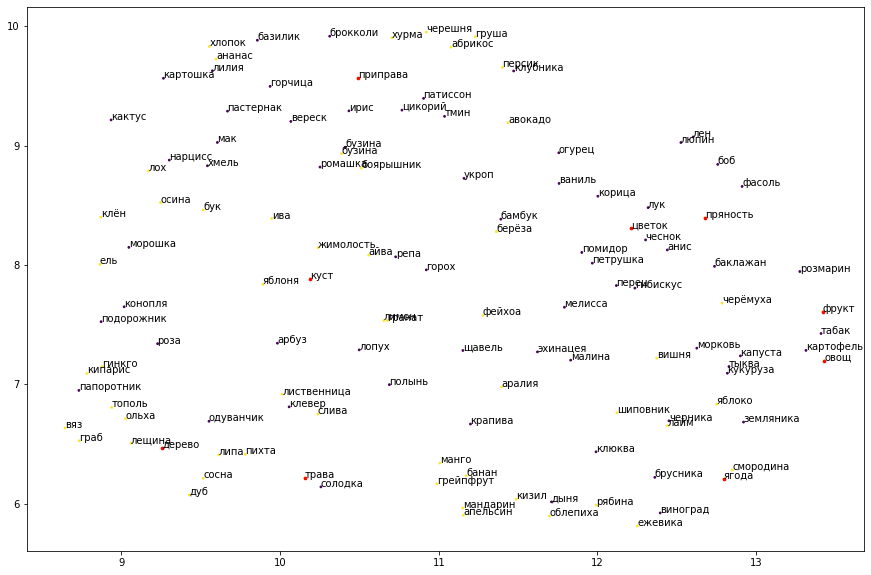

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=animal_type, s=3)

for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
    ind = all_names.index(word)
    ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)

for n, v in zip(all_names, umaped_vct):
    ax.annotate(n, (v[0], v[1]))

plt.show()

----

Теперь посмотрим какова размерность векторов, хранимых в модели, и сколько в ней слов.<br>
Размерность векторов 300 - с запасом. Почти 250 000 слов - тоже очень хорошо.

In [48]:
print(model_w2v.vector_size)
print(len(model_w2v.index2word))

300
196620


In [49]:
model_w2v.index2word[:50]

['год_NOUN',
 'мочь_VERB',
 'человек_NOUN',
 'время_NOUN',
 'работа_NOUN',
 'новый_ADJ',
 'становиться_VERB',
 'также_ADV',
 'очень_ADV',
 'день_NOUN',
 'первый_ADJ',
 'компания_NOUN',
 'являться_VERB',
 'ребенок_NOUN',
 'иметь_VERB',
 'система_NOUN',
 'место_NOUN',
 'получать_VERB',
 'большой_ADJ',
 'жизнь_NOUN',
 'вопрос_NOUN',
 'хороший_ADJ',
 'должный_ADJ',
 'вид_NOUN',
 'город_NOUN',
 'сайт_NOUN',
 'случай_NOUN',
 'дело_NOUN',
 'дом_NOUN',
 'сделать_VERB',
 'давать_VERB',
 'говорить_VERB',
 'россия_PROPN',
 'возможность_NOUN',
 'высокий_ADJ',
 'страна_NOUN',
 'область_NOUN',
 'мир_NOUN',
 'работать_VERB',
 'данный_ADJ',
 'начинать_VERB',
 'часть_NOUN',
 'качество_NOUN',
 'знать_VERB',
 'сказать_VERB',
 'позволять_VERB',
 'хорошо_ADV',
 'хотеть_VERB',
 'нужно_ADV',
 'принимать_VERB']

У нас есть смысл отдельных слов. Построим на его основе смысл текста как среднее арифметическое всех векторов для слов, составляющих данный текст.

In [50]:
index2word_set = set(model_w2v.index2word)

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


Рассчитаем вектора всех текстов - они нам еще пригодятся.

In [51]:
w2v_vectors = [text_to_vec(text) for text in news.News]

Найдем текст, самый похожий на некоторый текст.

In [52]:
vpos = 71
v1 = text_to_vec(news.News[vpos])

ms = np.argmin([np.linalg.norm(v1-w2v_vectors[i]) for i in range(news.News.shape[0]) if i!=vpos])
print(ms, news.News[vpos])
if ms>vpos:
    print(ms+1, news.News[ms+1])
else:
    print(ms, news.News[ms])

6490 -----
В Москве в павильоне выставочного комплекса ВДНХ прошло дефиле коллекции модного дома Chanel «Париж — Гамбург» Métiers d’art 2017/18, сообщает корреспондент «Ленты.ру». Коллекция, впервые показанная в декабре 2017 года в новом гамбургском концертном зале — Эльбской филармонии. Декорации, отсылавшие к теме грузового порта Гамбурга, были воссозданы на ВДНХ в павильоне №69 с учетом его архитектурных особенностей. В основе идеи коллекции — форма моряков торгового флота, переработанная креативным директором дома Карлом Лагерфельдом. Среди гостей показа были посланница дома Каролин де Мегрэ, актрисы Джоанна Прайсс, Равшана Куркова, Марин Вакт, Ирина Старшенбаум, Ксения и Полина Кутеповы, корейская модель Су Джу Пак, балерина Анастасия Шевцова. После показа гостей ждало афтерпати с участием DJ Су Джу Пака, певицы Mabel и Гриши Урганта. Во время Недели высокой моды в Париже в январе 2018 года компания Chanel представила ювелирную коллекцию haute joaillerie под названием L'Esprit du 

Теперь посмотрим как разспределятся тексты в новом пространстве.

In [53]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(w2v_vectors)

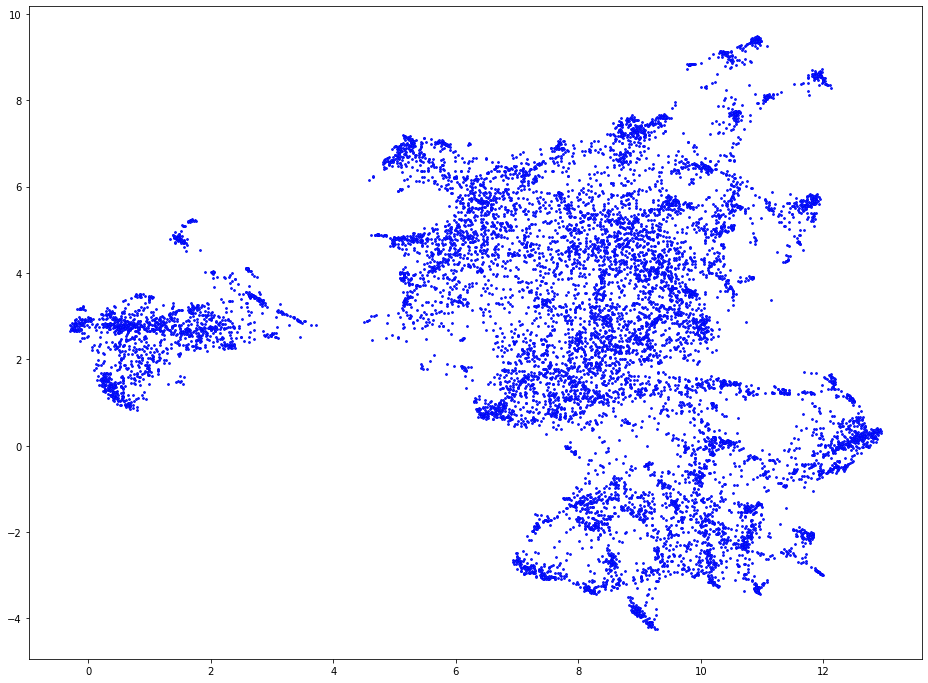

In [54]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

In [55]:
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice

Посмотрим что будет, если обучить на данных после преобразования пространства.

92


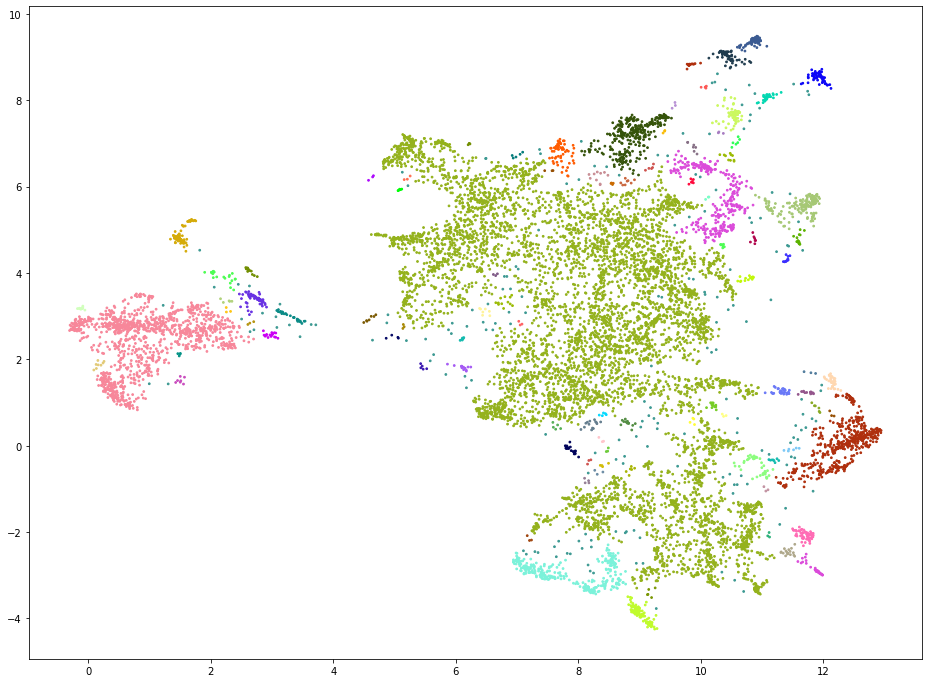

In [56]:
db=DBSCAN(eps=0.12, min_samples=3)
db_clusters=db.fit_predict(umaped_vct)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()


In [57]:
clusters=list(set(db_clusters))

for c in clusters:
    print(c)
    cntr=0
    for i, a in enumerate(news.Header):
        if db_clusters[i]==c:
            print(a)
            cntr+=1
            if cntr==3:
                break

0
«Королева дерьмовых роботов» перенесла операцию на мозге
СК заинтересовался задержанием аутиста московскими полицейскими
Киевляне перекрыли проспект из-за сбитого полицейскими ребенка-велосипедиста
1
У Су-57 нашли «тайные ноу-хау»
Донецкие «Чебурашки» отомстили за гибель командира ополчения Мамая
«Центр Хруничева» усохнет
2
Знарок лишился еще одного поста
Уткин обозвал Черчесова медной статуей
Капитана «Реала» завалили угрозами за травму Салаха
3
Российская легкоатлетка одержала 40 побед подряд
Серена Уильямс попала на Шарапову
21-летняя россиянка обыграла вторую ракетку мира на «Ролан Гаррос»
4
Британка скатилась с горы и осталась жива
Шестилетний мальчик спас от смерти более тысячи собак
Львы, тигры, ягуар и медведь устроили побег из немецкого зоопарка
5
Нидерланды задумались привлечь Киев к ответственности за крушение «Боинга»
Поляки спустя восемь лет обнаружили следы взрывчатки на Ту-154 Качиньского
Нидерланды сняли с Украины ответственность за гибель MH17 в Донбассе
6
Выявлен но

Попробуем теперь провести кластеризацию в исходном пространстве.

Предварительно прикинем значение $\epsilon$ по расстоянию до ближайших соседей. Для этого используем функцию для построения графа k ближайших соседей из sklearn.

In [58]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

In [59]:
# Строит разреженный граф, в котором на месте связей с ближайшими соседями стоят единицы.
wm = kneighbors_graph(w2v_vectors, 3, n_jobs=-1)

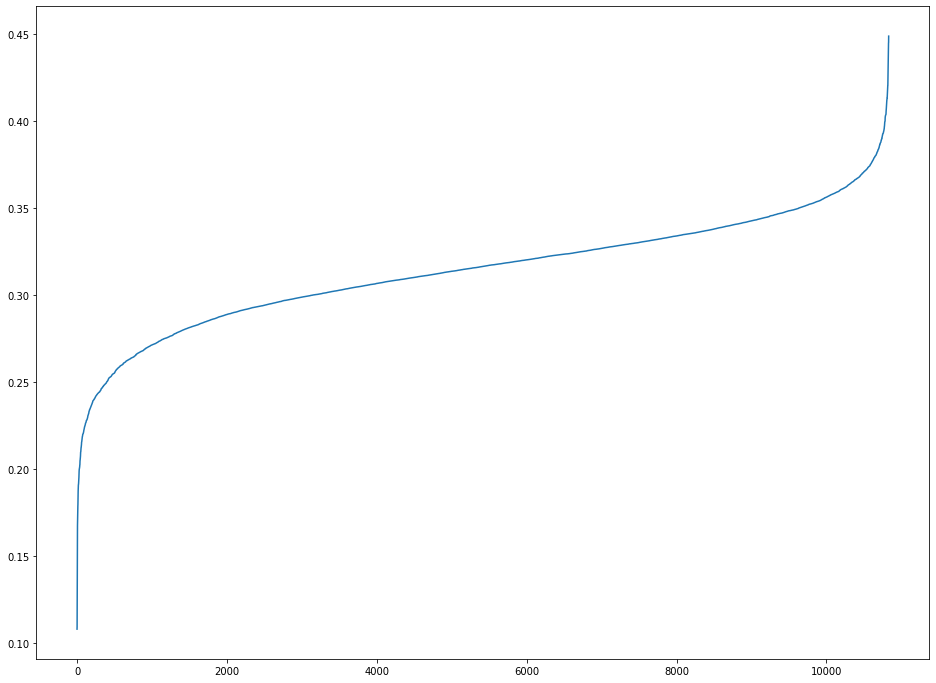

In [60]:
nzr, nzc = wm.nonzero()
neighbours = np.zeros(len(w2v_vectors))
for r, c in zip(nzr, nzc):
    neighbours[r] += np.linalg.norm(v1-w2v_vectors[c])
    
neighbours=sorted(neighbours/3)
fig, ax = plt.subplots()
ax.plot(range(len(neighbours)), neighbours)
plt.show()    

Теперь проведем кластеризацию.

68


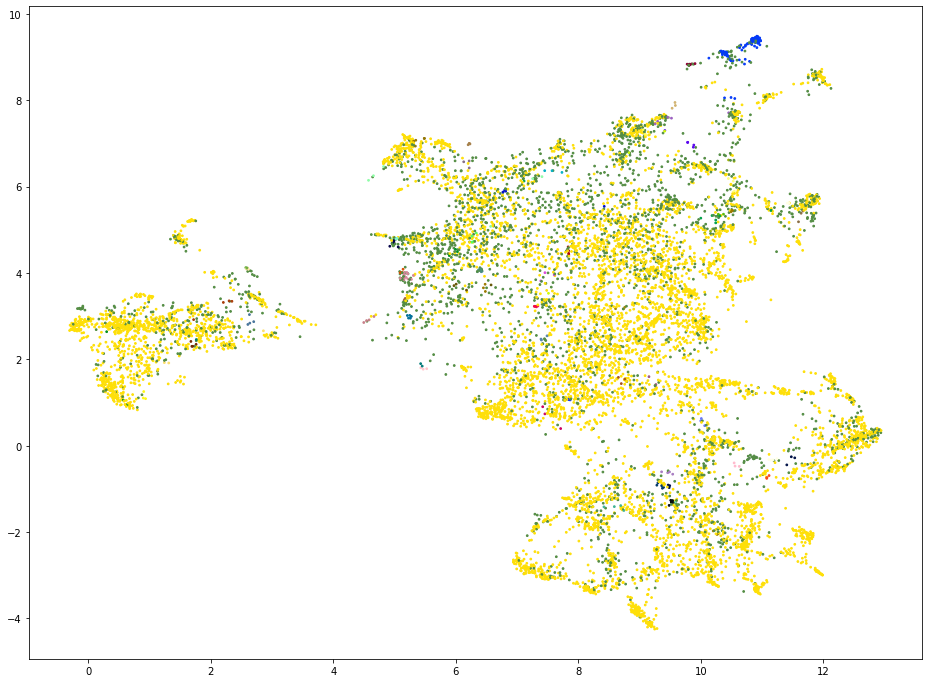

In [61]:
db=DBSCAN(eps=0.17, min_samples=3)
db_clusters=db.fit_predict(w2v_vectors)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [62]:
clusters=list(set(db_clusters))

for c in clusters:
    print(c)
    cntr=0
    for i, a in enumerate(news.Header):
        if db_clusters[i]==c:
            print(a)
            cntr+=1
            if cntr==3:
                break

0
«Королева дерьмовых роботов» перенесла операцию на мозге
У Су-57 нашли «тайные ноу-хау»
Знарок лишился еще одного поста
1
Выявлен новый способ продления жизни
Доказана эффективность вакцины против рака мозга
Ученые обнаружили дешевый способ борьбы с раком
2
На «Пикнике Афиши» выступят Земфира и Дельфин
Выступления фестиваля Primavera Sound можно будет пережить заново
Migos отменили выступление на фестивале Primavera
3
В Москве и Петербурге покажут «Лоуренса Аравийского»
В городах России пройдут показы спагетти-вестерна «Однажды на Диком Западе»
Лучшие фильмы Кубрика покажут в трех городах России
4
В результате извержения вулкана в Гватемале погибли люди
Число жертв извержения вулкана в Гватемале выросло до 25
Число жертв извержения вулкана в Гватемале превысило 60
5
Актер и музыкант Тимур Миргалимов найден мертвым
Умер актер из «Убойной силы» и «Улиц разбитых фонарей»
Умер сыгравший Леньку в фильме «Любовь и голуби» актер
6
Мальчикам разрешили ходить в школу в юбке
Девочкам-подростка

Теперь вернемся к научным статьям.

При объединении всех векторов текста происходит размытие его смысла за счет того, что некоторые понятия хоть и являются близкими, но имеют различия. Вместо того, чтобы брать само слово, давайте объединим все слова одной группы и будем брать их центроид. Заодно посмотрим какие слова попадают в одну группу.

In [63]:
%%time
sci_texts['NText'] = sci_texts['Text'].map(lambda x:' '.join(normalizePymorphy(x)))

CPU times: user 29.1 s, sys: 63.7 ms, total: 29.2 s
Wall time: 29.2 s


In [64]:
%%time
dct = {}
# Бежим по статьям.
for article in sci_texts.NText:
    # Берем слово. Потом берем 4 соседа слева и справа.
    words = article.split(' ')
    for i, word1 in enumerate(words[4:-5]):
        for j, word2 in enumerate(words[i-4:i+4]):
            if i!=j:
                # Если основного слова еще не встречалось - добавляем его.
                if word1 not in dct.keys():
                    dct[word1] = {}
                cdict = dct[word1]
                # Говорим, что эти два слова еще раз встретились вместе.
                cdict[word2] = cdict.get(word2, 0) +1


CPU times: user 47.7 s, sys: 412 ms, total: 48.1 s
Wall time: 48.1 s


In [65]:
# Возьмем слова, которые встречаются больше чем с 10 другими словами, каждое из которых встречается чаще 5 раз.
fd = {w:{k:np.log10(i) for k,i in dct[w].items() if i>5} for w in dct.keys() 
      if len([dct[w][k] for k in dct[w] if dct[w][k]>5])>10}

In [66]:
# Берем вектора слов.
sci_vects = []
sci_words = []
for word in fd.keys():
    try:
        sci_vects.append(model_w2v[word])
        sci_words.append(word)
    except Exception:
        pass

In [67]:
word

'хромченко_NOUN'

In [68]:
# Посмотрим как вообще слова распределены в пространстве.
sci_map = UMAP()
sci_reduced = sci_map.fit_transform(sci_vects)

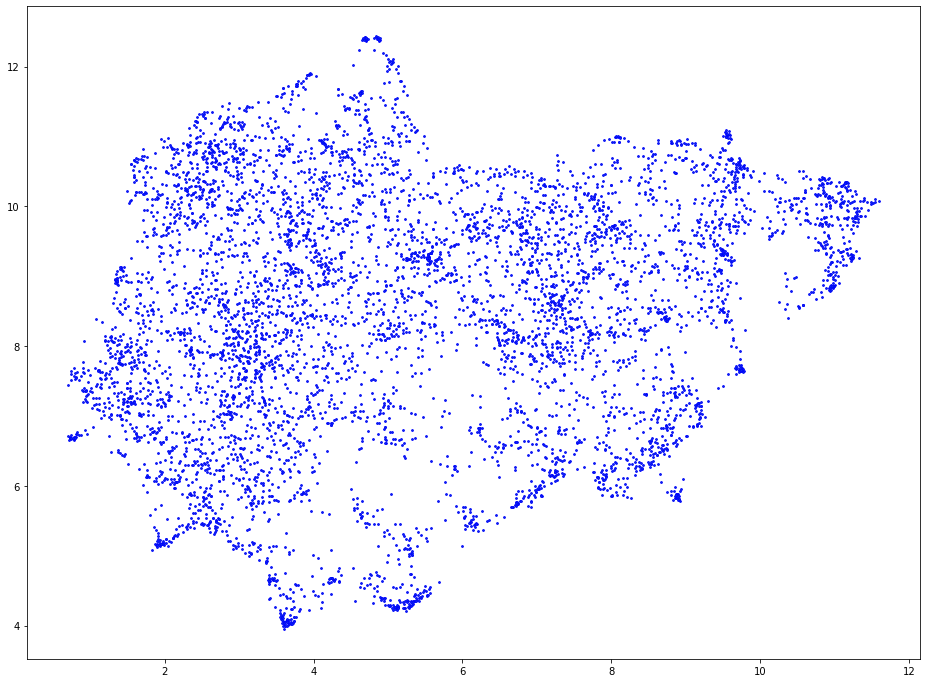

In [69]:
fig, ax = plt.subplots()
ax.scatter(sci_reduced[:, 0], sci_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=3)
plt.show()

In [70]:
%%time
# Кластеризуем, в среднем по два слова на кластер.
sci_clust_no = int(len(sci_vects)/2)
km_clustering = KMeans(n_clusters=sci_clust_no)
sci_clusters = km_clustering.fit_predict(sci_vects)

CPU times: user 22min 14s, sys: 12min 26s, total: 34min 41s
Wall time: 5min 51s


In [71]:
# Какие слова попадают в один кластер.
clust_no = 21

sci_words_sorted = sorted(zip(sci_clusters, sci_words), key= lambda x:x[0])
print([word[1] for word in sci_words_sorted if word[0]==clust_no])

['седиментация_NOUN', 'оседание_NOUN', 'диагенез_NOUN', 'осадконакопление_NOUN']


In [72]:
# Посчитаем координаты центроидов.
cur_clust = sci_words_sorted[0][0]
cur_coord = np.array(model_w2v[sci_words_sorted[0][1]])
cur_count = 1
clust_coord = []

for i, word in enumerate(sci_words_sorted[1:]):
    if cur_clust == sci_words_sorted[i+1][0]:
        cur_coord += model_w2v[sci_words_sorted[i+1][1]]
        cur_count += 1
    else:
        clust_coord.append(cur_coord/cur_count)
        cur_clust = sci_words_sorted[i+1][0]
        cur_coord = np.array(model_w2v[sci_words_sorted[i+1][1]])
        cur_count = 1
        
clust_coord.append(cur_coord/cur_count)


In [73]:
# Эта функция берет центры кластеров вместо слов.
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sci_words_sorted}

def text_to_vec_centr(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in sci_words_d.keys():
            n_words = n_words + 1
            text_vec = np.add(text_vec, clust_coord[sci_words_d[word]]) 
        else:
            try:
                text_vec = np.add(text_vec, model_w2v[word]) 
                n_words = n_words + 1
            except Exception:
                pass
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


In [74]:
# Строим вектора для слов.
sci_vect2 = []
for text in tqdm(sci_texts.Text):
    sci_vect2.append(text_to_vec_centr(text))

In [75]:
# Посмотрим как распределятся документы при таком подходе.
umap_sci=UMAP()
umaped_vct=umap_sci.fit_transform(sci_vect2)

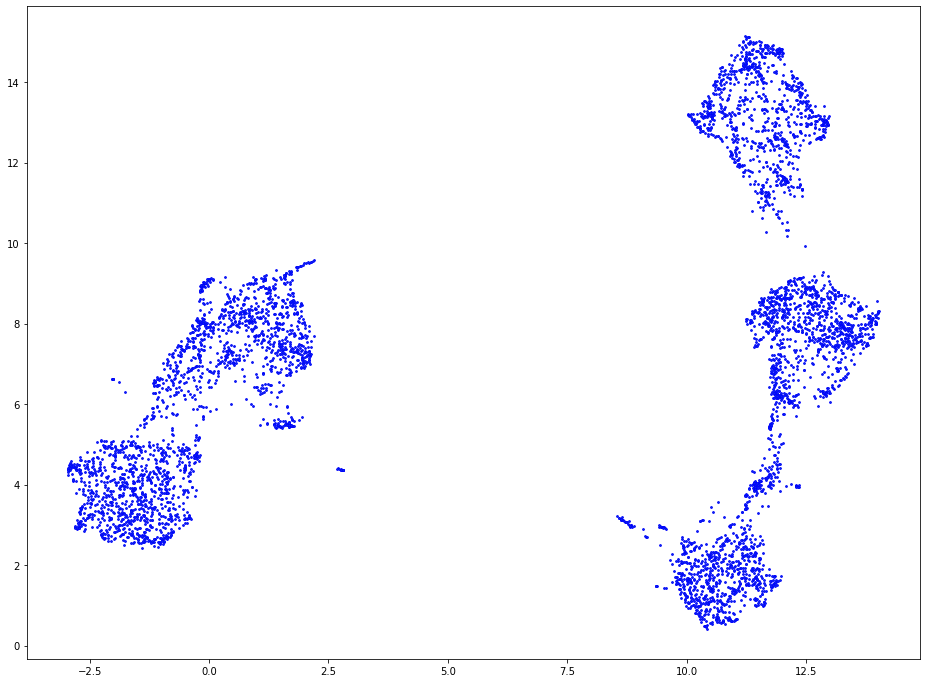

In [76]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

54


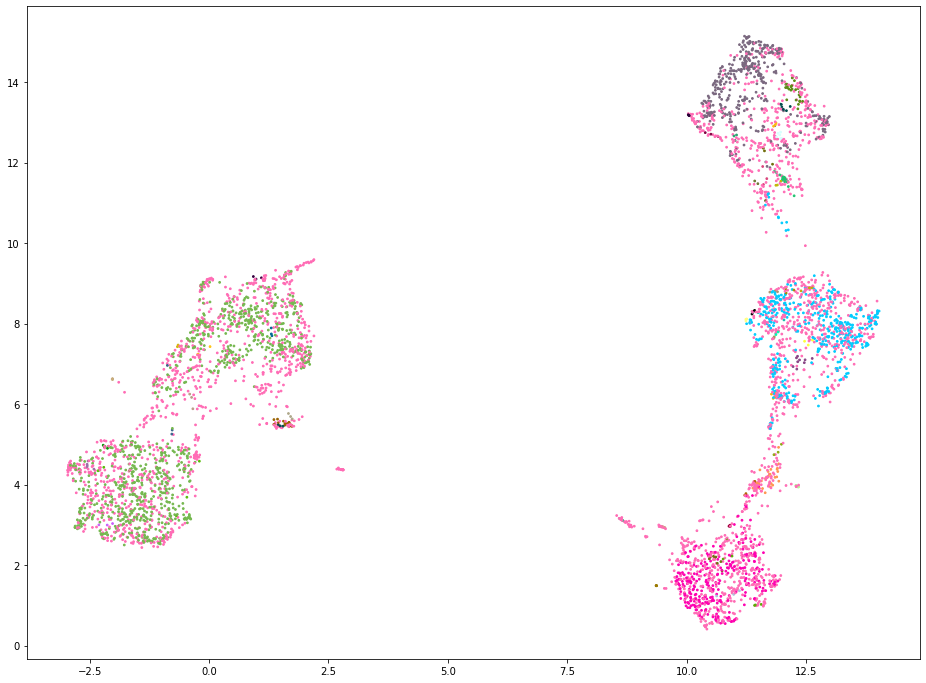

In [77]:
# Раскластеризуем документы.
db=DBSCAN(eps=0.08, min_samples=3)
db_clusters=db.fit_predict(sci_vect2)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [78]:
# Посмотрим на них глазами.
clusters=list(set(db_clusters))

for c in clusters:
    print('          __ ', c, ' __')
    cntr=0
    for i, a in enumerate(sci_texts.Text):
        if db_clusters[i]==c:
            print(a[:200])
            cntr+=1
            if cntr==3:
                break

          __  0  __
                                               ﻿удк 641.1/.3, 641.16                технологические аспекты показателя «активность воды» и его роль в обеспечении качества продукции общественного питан
                                               ﻿удк 641.1/.3, 641.16                технологические аспекты показателя «активность воды» и его роль в обеспечении качества продукции общественного питан
                                               ﻿проблемы формировйния и сохранения качества жененного мармепапа                табаторович а.н.,                аспирант сибирского университета потреби
          __  1  __
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя
                                               ﻿оптимизация производственного ассортимента плавленых сыров на основе товарного консалтинга                н.

А теперь поступим по-другому. Разделим слова на 50 кластеров, а в качестве вектора признаков документа будем брать число слов данного документа, попадающих в каждый кластер.

In [79]:
%%time
cluster_space_size = 50
km_clustering = KMeans(n_clusters=cluster_space_size)
sci_clusters = km_clustering.fit_predict(sci_vects)

CPU times: user 46.1 s, sys: 33.5 s, total: 1min 19s
Wall time: 14.4 s


In [80]:
# Эта функция берет для документа количество слов по кластерам..
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sci_words_sorted}

def text_to_centoids(text):
    text_vec = np.zeros((cluster_space_size,), dtype="float32")
    n_words = 0

    for sent in normalizePymorphy(text):
        for word in sent:
            if word in sci_words_d.keys():
                n_words = n_words + 1
                text_vec[clust_coord[sci_words_d[word]]] += 1
    
    if np.sum(text_vec) != 0:
        text_vec /= np.sum(text_vec)
    return text_vec


In [81]:
clust_coord[sci_words_d['процесс_NOUN']]

array([ 4.04470e-02, -3.98800e-03,  1.11400e-03, -1.56500e-03,
        6.45370e-02, -7.96240e-02,  4.66350e-02, -3.29250e-02,
       -1.41430e-02,  8.69380e-02, -4.67300e-03, -5.26580e-02,
        1.37880e-02, -2.86750e-02, -5.35310e-02, -5.29950e-02,
        1.44490e-02, -7.23880e-02, -1.25670e-02, -5.48660e-02,
        5.29610e-02, -1.05060e-02,  2.49140e-02, -9.88500e-03,
       -1.52450e-02,  4.15680e-02,  5.18310e-02,  3.45090e-02,
       -7.86200e-03, -6.38200e-03, -8.40150e-02,  4.57990e-02,
       -2.89400e-03, -4.24810e-02,  1.44500e-02, -8.44400e-03,
       -9.77600e-03, -8.53950e-02, -1.62200e-02, -9.32930e-02,
        6.92100e-02, -1.57870e-02, -8.50000e-02, -3.09930e-02,
       -3.46800e-02, -7.84510e-02,  4.50060e-02, -2.52400e-02,
        8.62420e-02,  3.34210e-02,  5.05370e-02, -1.82630e-02,
       -7.30700e-03, -1.26520e-02, -2.34500e-03, -4.64850e-02,
        1.27570e-02,  2.96980e-02,  6.03150e-02, -1.21400e-02,
       -7.64200e-03, -9.79990e-02,  3.94980e-02, -2.060

In [82]:
# Эта функция берет для документа количество слов по кластерам..
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sorted(zip(sci_clusters, sci_words), key= lambda x:x[0])}

def text_to_centoids(text):
    text_vec = np.zeros((cluster_space_size,), dtype="float32")
    n_words = 0

    for word in text.split():
        if word in sci_words_d.keys():
            text_vec[sci_words_d[word]] += 1
    
    if np.sum(text_vec) != 0:
        text_vec /= np.sum(text_vec)
    return text_vec


In [ ]:
# Строим вектора для слов.
sci_vect3 = []
for text in tqdm(sci_texts.NText):
    sci_vect3.append(text_to_centoids(text))

In [ ]:
# Посмотрим как распределятся документы при таком подходе.
umap_sci=UMAP()
umaped_vct=umap_sci.fit_transform(sci_vect3)

fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

In [ ]:
# Раскластеризуем документы.
db=DBSCAN(eps=0.075, min_samples=3)
db_clusters=db.fit_predict(sci_vect3)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [ ]:
# Посмотрим на них глазами.
clusters=list(set(db_clusters))

for c in clusters:
    print(f'__ {c} __')
    cntr=0
    for i, a in enumerate(sci_texts.Text):
        if db_clusters[i]==c:
            print(a[:200])
            cntr+=1
            if cntr==3:
                break

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sci_vect3, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print(len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test))
confusion_matrix(y_test, y_hat)

-----

А теперь посмотрим на FastText.

In [ ]:
from gensim.models.fasttext import FastText

In [ ]:
#model_ft = KeyedVectors.load_fasttext_format('data/araneum_none_fasttextskipgram_300_5_2018.tgz', binary=True)

#model_ft = FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.tgz')


In [ ]:
tmp_dict2 = {} # Кеш значимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    output = []
    # Делим на предложения самым страшным из возможных образов.
    sentences = text.split('.')
    for sentence in sentences:
        tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', sentence)
        # Берем предложения не менее чем из 5 слов.
        if len(tokens)<=4:
            continue
        words = []
        for t in tokens:
            # Если токен уже был закеширован, быстро возьмем результат из него.
            if t in tmp_dict2.keys():
                words.append(tmp_dict2[t])
            # Слово еще не встретилось, будем проводить медленный морфологический анализ.
            else:
                pv = morph.parse(t)
                if pv[0].tag.POS != None:
                    # Отправляем слово в результат, ...
                    words.append(pv[0].normal_form)
                    # ... и кешируем результат его разбора.
                    tmp_dict2[t] = pv[0].normal_form
        output.append(words)
                    
    return output

In [ ]:
all_sentences = []
for text in tqdm(news.News):
    all_sentences.extend(normalizePymorphy3(text))

In [ ]:
%%time
# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 3     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели


model_ft = FastText(all_sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

In [ ]:
model_ft.init_sims(replace=True)

In [ ]:
model_ft.save("data/fast_text_news.bin")

In [ ]:
model_ft = FastText.load("data/fast_text_news.bin")
#model_ft = FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.tgz')
# Мне не хватило 16 Гб оперативной памяти, чтобы загрузить эту модель.
#model_ft = FastText.load_fasttext_format("data/cc.ru.300.bin.gz")

In [ ]:
model_ft.wv['король_']-model_ft.wv['мужчина_']+model_ft.wv['женщина_']- model_ft.wv['королева_']


In [ ]:
from gensim.models import KeyedVectors # Семантические вектора.


In [ ]:
#model_ft.wv.most_similar(positive=[u'пожар'])
#model_ft.wv.most_similar(positive=[u'пожар'], negative=[u'пламя'])
#model_ft.wv.most_similar(positive=[u'топливо_'], negative=[u'нефть_'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
#model_ft.most_similar(positive=[u'король_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
#model_ft.most_similar(positive=[u'король_', u'женщина_'], negative=[u'мужчина_'])
#model_ft.most_similar(positive=[u'король', u'женщина'], negative=[u'мужчина'])
#model_ft.most_similar(positive=[u'президент', u'женщина'], negative=[u'мужчина'])
#model_ft.most_similar(negative=[u'король', u'мужчина'], positive=[u'женщина'])
#model_ft.most_similar(positive=[u'женщина_', u'король_'])
#model_ft.most_similar(positive=['германия_', 'москва_' ], negative=['берлин_'])
print(model_ft.wv.most_similar(positive=[u'король_', u'женщина_'], negative=[u'мужчина_']), "\n\n",
model_ft.wv.most_similar([model_ft.wv['король_']-model_ft.wv['мужчина_']+model_ft.wv['женщина_']]))

### Что осталось за кадром?

- BERT | ELMO (+ DeepPavlov)
- Онтологии.
- graph2vec (последовательность прослушанных песен, просмотр товаров, ...).